# 1. Import and Install Dependencies

## 1.1 Install Dependencies

In [3]:
!pip install tensorflow==2.11.0 tensorflow-io==0.31.0 matplotlib

  Using cached tensorflow-2.11.0-cp37-cp37m-win_amd64.whl (1.9 kB)
     ---------------------------------------- 22.9/22.9 MB 6.6 MB/s eta 0:00:00
     ---------------------------------------- 7.2/7.2 MB 6.7 MB/s eta 0:00:00
     -------------------------------------- 266.3/266.3 MB 4.3 MB/s eta 0:00:00
     ---------------------------------------- 1.5/1.5 MB 5.3 MB/s eta 0:00:00
  Using cached flatbuffers-23.5.26-py2.py3-none-any.whl (26 kB)
     ---------------------------------------- 4.3/4.3 MB 6.0 MB/s eta 0:00:00
     ---------------------------------------- 2.6/2.6 MB 6.7 MB/s eta 0:00:00
  Using cached termcolor-2.3.0-py3-none-any.whl (6.9 kB)
     ---------------------------------------- 6.0/6.0 MB 5.1 MB/s eta 0:00:00
  Using cached absl_py-2.0.0-py3-none-any.whl (130 kB)
  Using cached libclang-16.0.6-py2.py3-none-win_amd64.whl (24.4 MB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
     ---------------------

## 1.2 Load Dependencies

In [4]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf 
import tensorflow_io as tfio

# 2. Build Data Loading Function

## 2.1 Define Paths to Files

In [5]:
CAPUCHIN_FILE = os.path.join('data\ASI\ASI\wav', 'arctic_a0001.wav')

## 2.2 Build Dataloading Function

In [6]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

## 2.3 Plot Wave

In [7]:
wave = load_wav_16k_mono(CAPUCHIN_FILE)

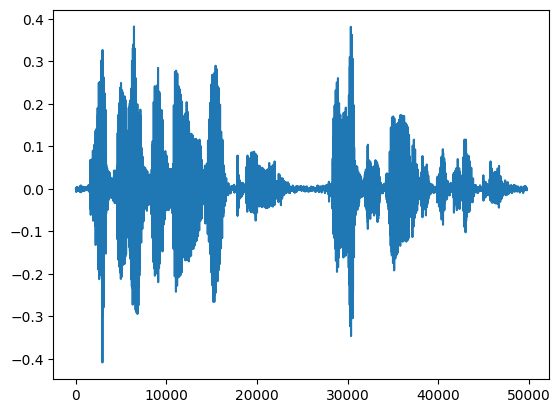

In [8]:
plt.plot(wave)
plt.show()

# 3. Create Tensorflow Dataset

## 3.1 Define Paths to Positive and Negative Data

## 3.2 Create Tensorflow Datasets

In [13]:
POS = os.path.join('data\ASI\ASI\wav')
pos = tf.data.Dataset.list_files(POS+'\*.wav')

<ShuffleDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

## 3.3 Add labels and Combine Positive and Negative Samples

# 4. Determine Average Length of a Capuchin Call

## 4.1 Calculate Wave Cycle Length

In [15]:
lengths = []
for file in os.listdir('data\ASI\ASI\wav'):
    tensor_wave = load_wav_16k_mono(os.path.join('data\ASI\ASI\wav', file))
    lengths.append(len(tensor_wave))

## 4.2 Calculate Mean, Min and Max

In [16]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=47233>

In [17]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=15360>

In [18]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=95167>

# 5. Build Preprocessing Function to Convert to Spectrogram

## 5.1 Build Preprocessing Function

In [40]:
def preprocess(file_path): 
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

In [23]:
wav = load_wav_16k_mono(CAPUCHIN_FILE)
wav

<tf.Tensor: shape=(49796,), dtype=float32, numpy=
array([ 3.82545586e-08, -1.08018995e-07,  6.74110581e-08, ...,
       -2.95577571e-03, -3.04298569e-03, -3.01190978e-03], dtype=float32)>

In [24]:
wav = wav[:48000]
zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
wav = tf.concat([zero_padding, wav],0)

In [29]:
spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
spectrogram = tf.abs(spectrogram)

spectrogram

<tf.Tensor: shape=(1491, 257), dtype=float32, numpy=
array([[1.1518221e-02, 1.6102569e-02, 2.6409639e-02, ..., 5.0090603e-06,
        3.3756444e-06, 2.0447187e-06],
       [1.7774771e-03, 2.4067197e-02, 6.8764281e-03, ..., 3.1296051e-06,
        1.4949526e-06, 2.7128845e-06],
       [5.2768152e-02, 5.3929608e-02, 6.0492776e-02, ..., 5.2874516e-06,
        4.5589304e-06, 4.6007335e-06],
       ...,
       [3.1427479e-01, 2.9451793e-01, 2.4569957e-01, ..., 6.6162665e-06,
        4.1056419e-06, 4.8279762e-06],
       [2.4167097e-01, 2.7876258e-01, 2.7600893e-01, ..., 4.7907870e-06,
        3.9439196e-06, 6.1616302e-06],
       [1.1638762e-01, 2.3192930e-01, 2.7674878e-01, ..., 2.5789773e-06,
        3.8736284e-06, 4.2356551e-06]], dtype=float32)>

In [30]:
# adding channel dim for NN
spectrogram = tf.expand_dims(spectrogram, axis=2)
spectrogram.shape

TensorShape([1491, 257, 1])

## 5.2 Test Out the Function and Viz the Spectrogram

In [46]:

filepath = pos.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [47]:
spectrogram = preprocess(filepath)

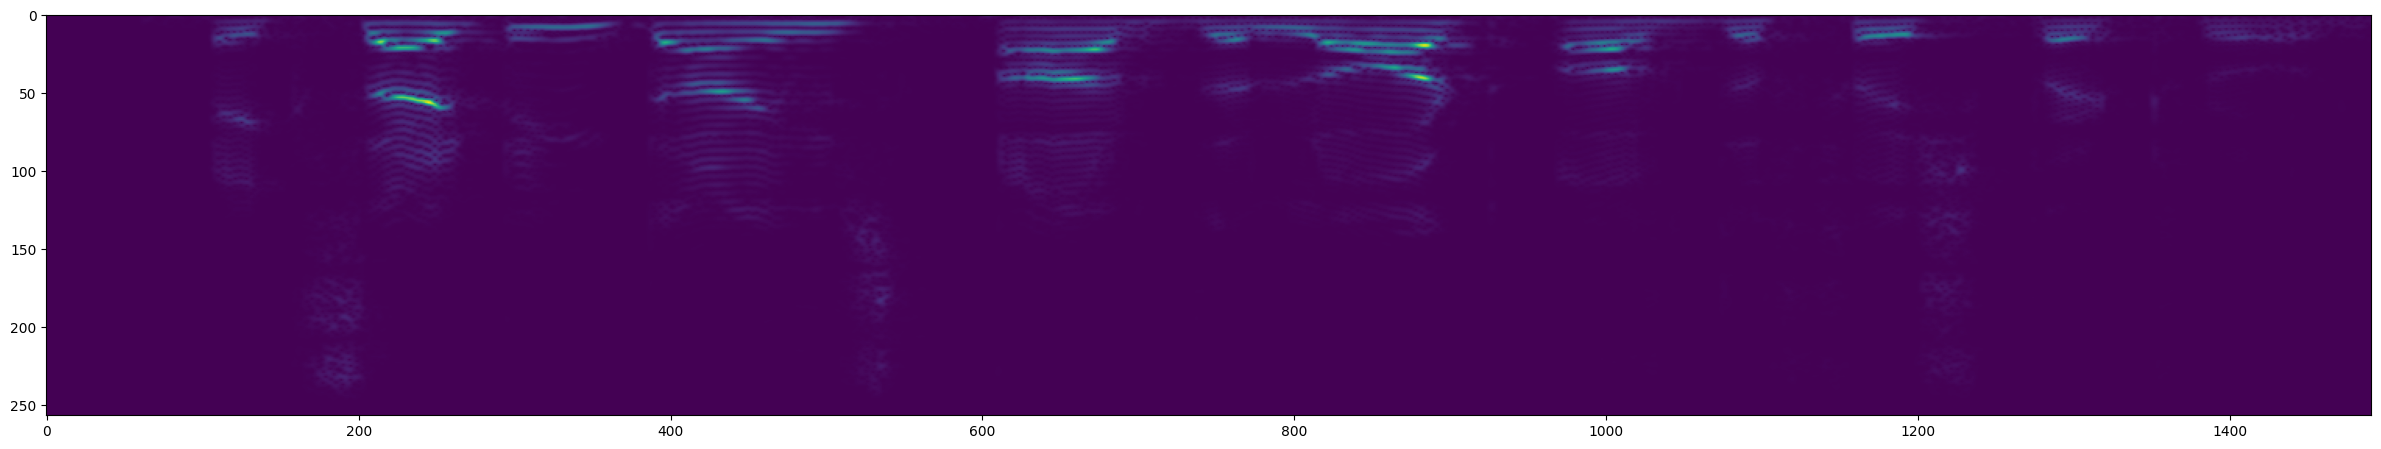

In [48]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [59]:
import librosa
import numpy as np
y, sr = librosa.load(CAPUCHIN_FILE)
print(f'y: {y[:10]}')
print(f'shape y: {y.shape}')
print(f'sr: {sr}')

S = librosa.feature.melspectrogram(y=y,
                                   sr=sr,
                                   n_mels=128 * 2,)
S_db_mel = librosa.amplitude_to_db(S, ref=np.max)

y: [-0.00354133 -0.00518272 -0.00475573 -0.00493641 -0.00453753 -0.00516859
 -0.0054061  -0.00554131 -0.00517327 -0.00581648]
shape y: (68626,)
sr: 22050


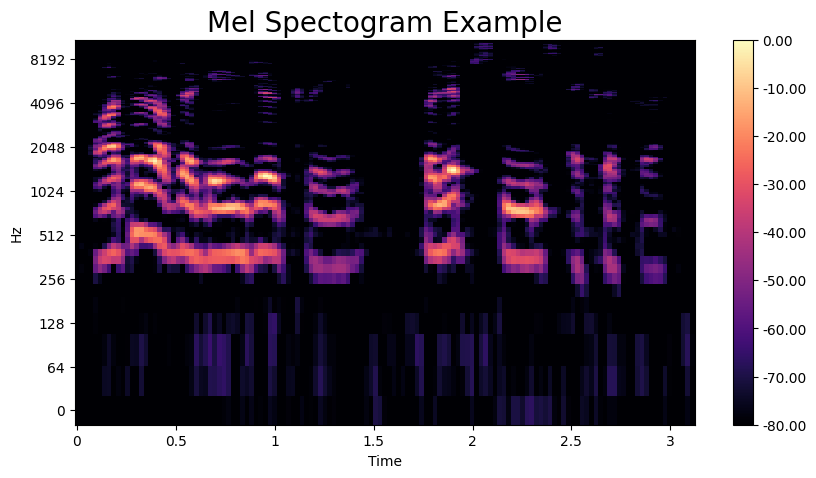

In [61]:
fig, ax = plt.subplots(figsize=(10, 5))
# Plot the mel spectogram
img = librosa.display.specshow(S_db_mel,
                              x_axis='time',
                              y_axis='log',
                              ax=ax)
ax.set_title('Mel Spectogram Example', fontsize=20)
fig.colorbar(img, ax=ax, format=f'%0.2f')
plt.show()